### 1. Instalação das bibliotecas necessárias

In [2]:
%pip install requests pandas plyer datetime IPython

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### 2. Importação das bibliotecas

In [3]:
import pandas as pd
import requests
from plyer import notification
from IPython.display import display
from datetime import datetime
import sqlite3



### 3. Def de criação dos alertas

In [5]:
def alerta (nivel,base,etapa):
    """Exibe notificação em caso de falha de carregamento de base"""
    if 1 == nivel:
        notification.notify(
            title = 'Alerta Baixo',
            message = 'Falha do carregamento da base {} na etapa de {}'.format(base,etapa),
            app_name = 'Previsão - Brasil', timeout = 10
            )
    elif 2 == nivel:
        notification.notify(
            title = 'Alerta Medio',
            message = 'Falha do carregamento da base {} no(a) {}'.format(base,etapa),
            app_name = 'Previsão - Brasil', timeout = 10
            )
    elif 3 == nivel:
        notification.notify(
            title = 'Alerta Alto',
            message = 'Falha do carregamento da base {} no(a) {}'.format(base,etapa),
            app_name = 'Previsão - Brasil', timeout = 10
            )        
    else: 
        print('Erro sistemico. Por favor, tente novamente.')

### 4. Def para extrair dados da API e se necessário retornar mensagem de erro

In [6]:

def extracao_api (url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()  
    elif response.status_code > 200 and response.status_code < 300:
        alerta(1,'para previsão','acesso')
    elif response.status_code >= 400 and response.status_code <500:
        alerta (2, 'para previsão', 'solicitação')
    elif response.status_code >= 500 and response.status_code <600:
        alerta (3, 'para previsão', 'servidor')
    else:
        alerta (1, 'para previsão', 'etapa desconhecida')

### 5.1. Trazendo os dados e trabalhando a  primeira tabela (estado)

In [8]:
url = "https://brasilapi.com.br/api/ibge/uf/v1"
data_json = extracao_api (url)
#estados_t = cabecalho(url,linhas=27)

regiao = [total_simples['regiao']['nome'] for total_simples in data_json]
nome = [total_simples['nome'] for total_simples in data_json]
sigla = [total_simples['sigla'] for total_simples in data_json]


total_simples = pd.DataFrame({
    'Nome': nome,
    'Sigla': sigla,
    'Regiao': regiao
})

sigla = 'RR'


estado = total_simples[total_simples['Sigla'] == sigla]
estado = estado.sort_values(by='Nome')


#Tabela 1: Estados e suas siglas
display(estado.head(len(estado)))


,Nome,Sigla,Regiao
3,Roraima,RR,Norte


### 5.2 Trazendo os dados e trabalhando a segunda tabela (Cidades do estado)

In [9]:
cidade = []
url = f'https://brasilapi.com.br/api/ibge/municipios/v1/{sigla}?providers=dados-abertos-br,gov,wikipedia'
data_json = extracao_api(url)

if data_json:
    cidade = [item['nome'] for item in data_json]

uf_e_cidades = pd.DataFrame({
    'Regiao': estado['Regiao'].values[0] if not estado.empty else None,
    'Estado': estado['Sigla'].values[0] if not estado.empty else None,
    'Cidade': cidade
})

uf = uf_e_cidades.sort_values(by='Cidade')


#Tabela 1: Estados e suas siglas do Centro-Oeste
display(uf.head(len(uf)))


,Regiao,Estado,Cidade
1,Norte,RR,ALTO ALEGRE
0,Norte,RR,AMAJARI
2,Norte,RR,BOA VISTA
3,Norte,RR,BONFIM
4,Norte,RR,CANTA
5,Norte,RR,CARACARAI
6,Norte,RR,CAROEBE
7,Norte,RR,IRACEMA
8,Norte,RR,MUCAJAI
9,Norte,RR,NORMANDIA


### 5.3 Trazendo os dados e trabalhando a terceira tabela (códigos CPTEC)

In [10]:
tabela_co = []
for cidade in uf['Cidade']:
    url = f'https://brasilapi.com.br/api/cptec/v1/cidade/{cidade}'
    data_json = extracao_api(url)
    if data_json:
        for item in data_json:
            if item['estado'] == sigla:  # Filtrar para cidades apenas do estado selecionado (evitar homonimas)
                df = pd.DataFrame({
                    'Estado': [item['estado']],
                    'Cidade': [item['nome']],
                    'Codigo': [item['id']]
                })
                tabela_co.append(df)
        
    # Combinar todos os DataFrames em um único DataFrame
total_co = pd.concat(tabela_co, ignore_index=True)
    # Exibir o DataFrame combinado com códigos
display(total_co.head(len(total_co)))

#Em testes, identificamos que as bases não estão atualizadas, apesar de ser a mesma API. Deste modo, algumas cidades são exibidas no quadro geral, mas não estão disponíveis na CPTEC. 
# Teste com estado do MS gerou divergência com perda de 3 itens



,Estado,Cidade,Codigo
0,RR,Alto Alegre,386
1,RR,Amajari,428
2,RR,Boa Vista,223
3,RR,Bonfim,940
4,RR,Cantá,1267
5,RR,Caracaraí,1312
6,RR,Caroebe,1371
7,RR,Iracema,2464
8,RR,Mucajaí,3396
9,RR,Normandia,3468


### 6 - RELACIONANDO TABELAS (Previsão meteorológica)

In [11]:

cid_temp = []

for codigos in total_co['Codigo']:
    url = f'https://brasilapi.com.br/api/cptec/v1/clima/previsao/{codigos}'
    data_json = extracao_api(url)

    if data_json:
        estado = data_json['estado']
        cidade = data_json['cidade']

        for clima in data_json['clima']:
             # Converter a data
            data_formatada = datetime.strptime(clima['data'], "%Y-%m-%d").strftime("%d/%m/%Y")
            df = pd.DataFrame({
                'Estado': [estado],
                'Cidade': [cidade],
                'Codigo': [codigos],
                'Data': [data_formatada],
                'Minima': [clima['min']],
                'Maxima': [clima['max']],
            })
            cid_temp.append(df)
    # Combinar todos os DataFrames em um único DataFrame
previsao = pd.concat(cid_temp, ignore_index=True)
    # Exibir o DataFrame combinado com códigos
display(previsao.head(len(previsao)))


,Estado,Cidade,Codigo,Data,Minima,Maxima
0,RR,Alto Alegre,386,08/07/2024,22,29
1,RR,Amajari,428,08/07/2024,23,29
2,RR,Boa Vista,223,08/07/2024,23,30
3,RR,Bonfim,940,08/07/2024,22,30
4,RR,Cantá,1267,08/07/2024,23,29
5,RR,Caracaraí,1312,08/07/2024,22,31
6,RR,Caroebe,1371,08/07/2024,22,32
7,RR,Iracema,2464,08/07/2024,23,30
8,RR,Mucajaí,3396,08/07/2024,23,30
9,RR,Normandia,3468,08/07/2024,22,29


### 7 - #def para carregamento de Dados no banco de dados

In [13]:
def carregar_dados_para_db(df, db_name="dados_ibge_cptec.db", table_name="previsao"):
    conn = sqlite3.connect(db_name)
    df.to_sql(table_name, conn, if_exists='replace', index=False)
    conn.close()
    print(f"Dados carregados para {db_name} na tabela {table_name}")


### 8 - Chamada da função para carregamento no db da tabela


In [14]:
carregar_dados_para_db(previsao)


Dados carregados para dados_ibge_cptec.db na tabela previsao


### 9 - #DEF para visualizar dados usando queries


In [15]:
def executar_query(query, db_name="dados_ibge_cptec.db"):
    conn = sqlite3.connect(db_name)
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

### 10 - Chamada da função para carregamento no db da tabela

In [16]:
query_previsao = "SELECT * FROM previsao"
df_previsao_query = executar_query(query_previsao)
print(df_previsao_query.head(len(df_previsao_query)))

   Estado              Cidade  Codigo        Data  Minima  Maxima
0      RR         Alto Alegre     386  08/07/2024      22      29
1      RR             Amajari     428  08/07/2024      23      29
2      RR           Boa Vista     223  08/07/2024      23      30
3      RR              Bonfim     940  08/07/2024      22      30
4      RR               Cantá    1267  08/07/2024      23      29
5      RR           Caracaraí    1312  08/07/2024      22      31
6      RR             Caroebe    1371  08/07/2024      22      32
7      RR             Iracema    2464  08/07/2024      23      30
8      RR             Mucajaí    3396  08/07/2024      23      30
9      RR           Normandia    3468  08/07/2024      22      29
10     RR           Pacaraima    3686  08/07/2024      19      27
11     RR        Rorainópolis    4449  08/07/2024      23      31
12     RR  São João da Baliza    4854  08/07/2024      22      32
13     RR            São Luiz    4983  08/07/2024      23      32
14     RR 

### 11 - Exemplo para erro na extração da base

In [17]:
url = f'https://brasilapi.com.br/api/cptec/v1/clima/previsao/'
data_json = extracao_api(url)

### 12. Hipoteses: Algumas cidades tendem a ter uma temperatura máxima consistentemente mais alta do que outras?


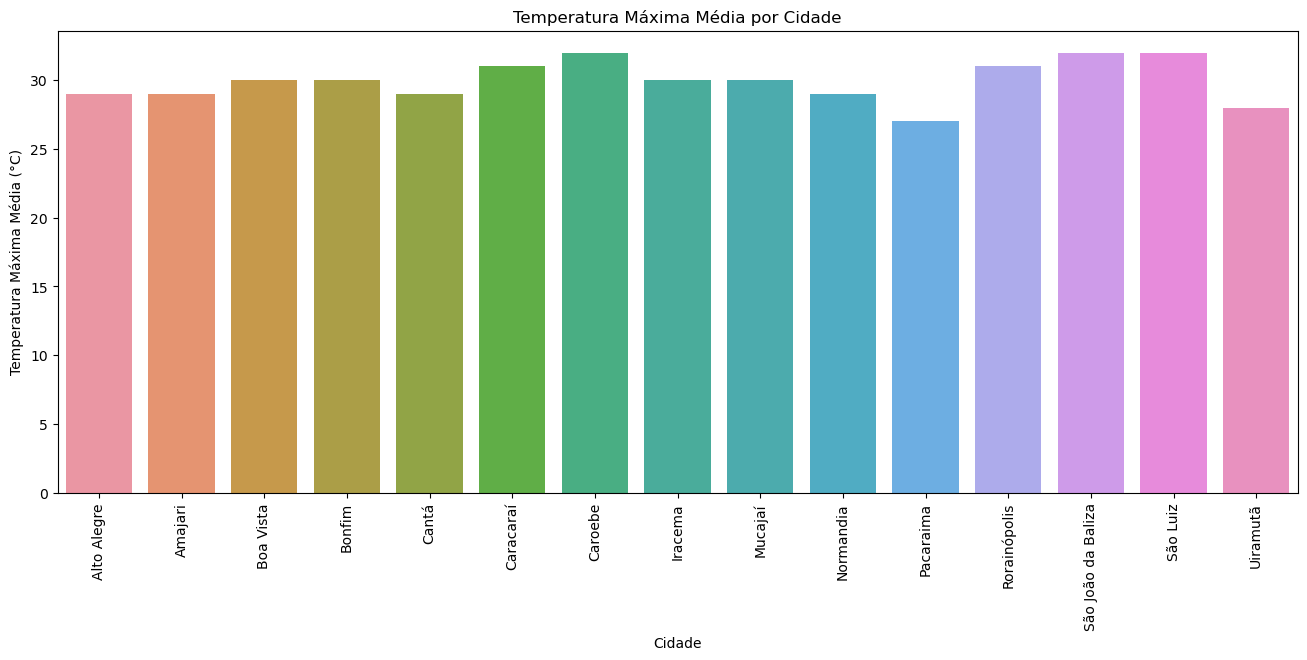

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


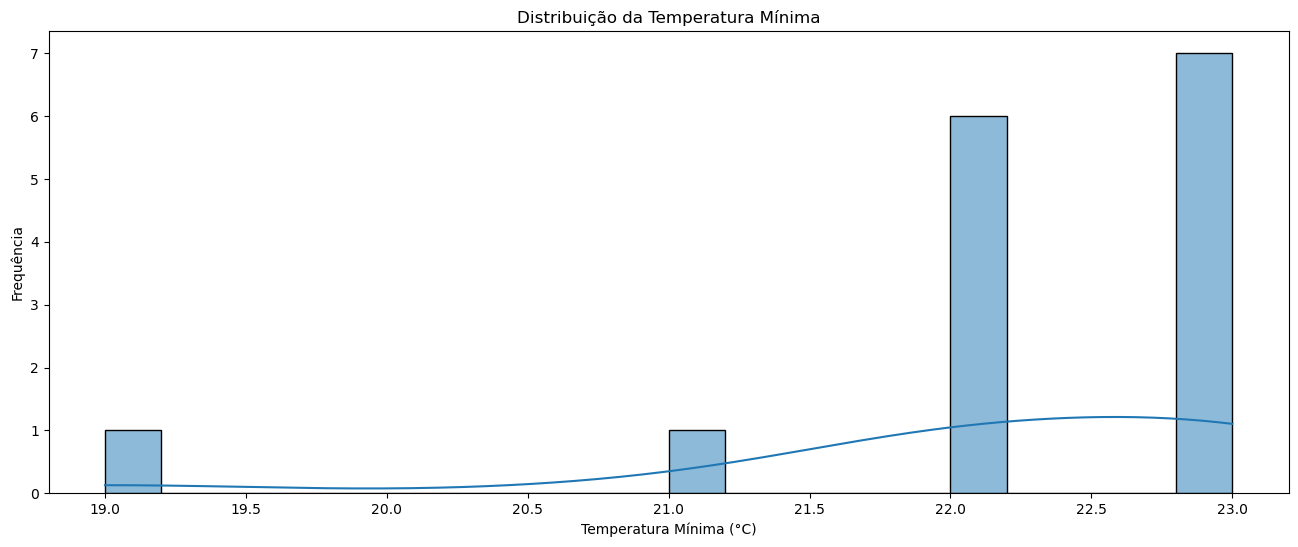

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


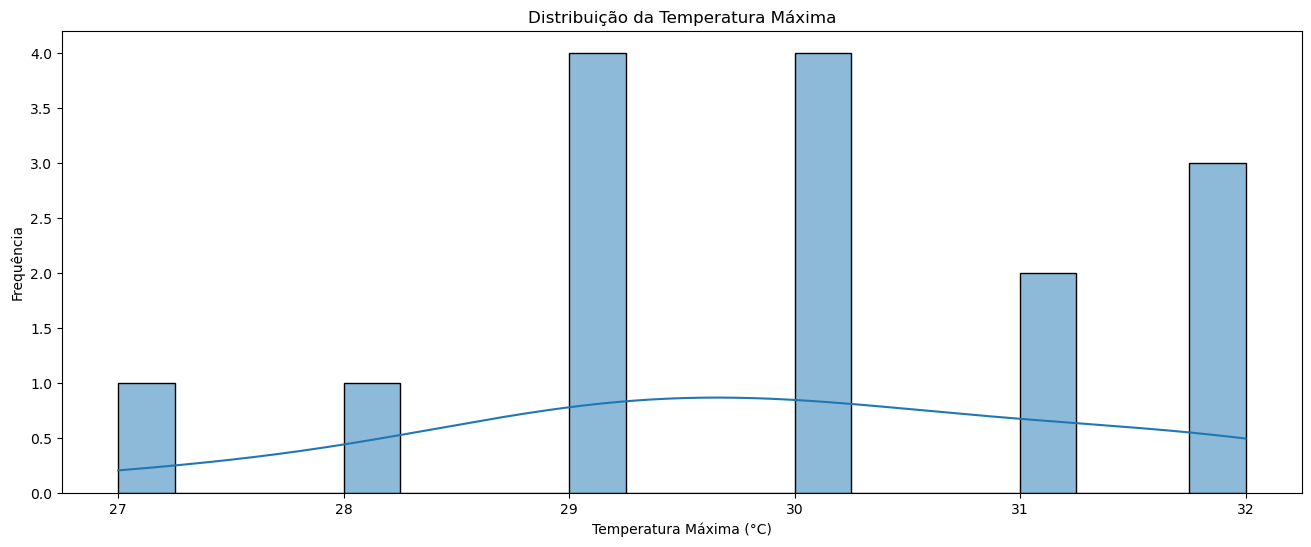

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Média das temperaturas máximas
df_temp_max = df_previsao_query.groupby('Cidade')['Maxima'].mean().reset_index()

# temperatura máxima média por cidade
plt.figure(figsize=(16, 6))
sns.barplot(data=df_temp_max, x='Cidade', y='Maxima')
plt.title('Temperatura Máxima Média por Cidade')
plt.xlabel('Cidade')
plt.ylabel('Temperatura Máxima Média (°C)')
plt.xticks(rotation=90)
plt.show()

# distribuição para a temperatura mínima
plt.figure(figsize=(16, 6))
sns.histplot(df_previsao_query['Minima'], bins=20, kde=True)
plt.title('Distribuição da Temperatura Mínima')
plt.xlabel('Temperatura Mínima (°C)')
plt.ylabel('Frequência')
plt.show()

# distribuição para a temperatura máxima
plt.figure(figsize=(16, 6))
sns.histplot(df_previsao_query['Maxima'], bins=20, kde=True)
plt.title('Distribuição da Temperatura Máxima')
plt.xlabel('Temperatura Máxima (°C)')
plt.ylabel('Frequência')
plt.show()